<a href="https://colab.research.google.com/github/alchua1996/MachineLearning/blob/master/Wavelet_Scattering_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries



In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Test Image

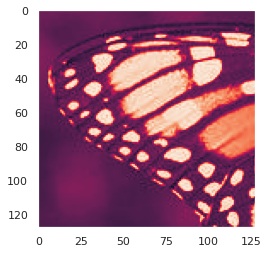

In [4]:
# Load image and crop to make 128 x 128
img_orig = mpimg.imread('/content/drive/MyDrive/butterfly.jpg')
img = img_orig[44:172,44:172] / 255
plt.imshow(img)
plt.grid(False)

#Making the Scattering Transform

In [5]:
def rot_inv(theta):
    mat = np.zeros((2,2))
    mat[0][0] = np.cos(-theta)
    mat[1][1] = mat[0][0]
    mat[0][1] = -np.sin(-theta)
    mat[1][0] = -mat[0][1]
    return mat

In [6]:
def high_pass_wavelets(N, sigma, xi, L, J):
    C2 = 0.277055
    psi = np.zeros((N,N,L,J), dtype = 'complex')
    for n in range(N):
        for m in range(N):
            for k in range(L):
                for j in range(J): 
                     x = np.zeros(2, dtype = 'complex')
                     x[0] = (n-int(N/2)) / 2**j
                     x[1] = (m-int(N/2)) / 2**j
                     z = np.dot(rot_inv(np.pi * k / L), xi)
                     z = np.dot(z,x)
                     psi[n,m,k,j] =  2**(-2*j) * (np.exp(1j * z) - C2) *  1/(2 * np.pi * sigma**2) * np.exp(-np.dot(x,x) /(2* sigma**2))
    return psi

In [7]:
def low_pass_wavelet(N, sigma,j):
    phi = np.zeros((N,N), dtype = 'complex')
    for n in range(N):
        for m in range(N):
            x = np.zeros(2, dtype = 'complex')
            x[0] = (n-int(N/2))/2**j
            x[1] = (m-int(N/2))/2**j
            phi[n,m] =  2**(-2*j) * 1/(2 * np.pi * sigma**2) * np.exp(-np.dot(x,x) /(2* sigma**2))
    return phi

In [8]:
def convolve_frequency(img, filters):
    img_fft = np.fft.fft2(img)
    filter_fft = np.fft.fft2(filters)
    conv = np.fft.ifft2(img_fft * filter_fft)
    conv = np.fft.fftshift(conv)
    return conv

In [9]:
def get_next_layer(coeffs,filters,num_angles, d):
    #current number of wavelet coefficients in coeffs array
    num_coeffs = num_angles**(d-1)
    N = coeffs.shape[0]
    count = 0
    if(d == 1):
        next_layer = np.zeros((N,N, num_angles), dtype = 'complex')
        for m in range(num_angles):
            next_layer[:,:,count] = convolve_frequency(coeffs, filters[:,:,m])
            count += 1 
    else:
        next_layer = np.zeros((N,N, num_coeffs * num_angles), dtype = 'complex')
        count = 0
        for n in range(num_coeffs):
            for m in range(num_angles):
                next_layer[:,:,count] = convolve_frequency(coeffs[:,:,n], filters[:,:,m])
                count += 1 
    return next_layer


In [10]:
def wavelet_scattering_transform(img, psi, phi, xi, num_angles, depth):
    #number of wavelet coefficients
    num_coeff = 0
    for n in range(depth+1):
        num_coeff += num_angles**n

    #wavelet coefficient index
    count = 0

    #initialize array to store all wavelet coefficients
    wavelet_coefficients = np.zeros((img.shape[0],img.shape[0],num_coeff), dtype = 'complex')

    for d in range(depth+1):
        if d == 0:
           curr_layer = img 
           wavelet_coefficients[:,:,count] = convolve_frequency(curr_layer, phi)
           count+=1
        else: 
            next_layer = get_next_layer(curr_layer, psi[:,:,:,d-1], num_angles, d)
            next_layer = np.abs(next_layer)
            for n in range(num_angles**d):
                wavelet_coefficients[:,:,count] = convolve_frequency(next_layer[:,:,n],phi)
                count += 1 
            curr_layer = next_layer        
    return wavelet_coefficients

# Test Scattering Transform on Butterfly

In [17]:
sigma1 = 0.85
sigma2 = 1.0
xi = [0 , np.pi * 3/5]
depth  = 2
num_angles = 4
psi = high_pass_wavelets(img.shape[0], sigma1, xi, num_angles, depth)
phi = low_pass_wavelet(img.shape[0], sigma2 , depth)
scattering_coeff = wavelet_scattering_transform(img, psi, phi, xi, num_angles, depth)
scattering_coeff = np.abs(scattering_coeff)

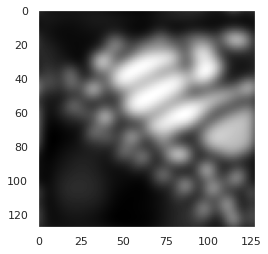

In [18]:
plt.imshow(scattering_coeff[:,:,0], cmap = 'gray')
plt.grid(False)

# First Layer Scattering Coefficients

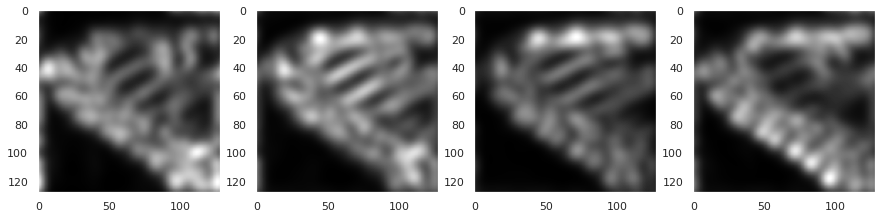

In [19]:
c = 1
plt.figure(figsize = (15,4))
for j in range(num_angles):
    plt.subplot(1,num_angles,c)
    plt.imshow(scattering_coeff[:,:,j+1], cmap = 'gray')
    plt.grid(False)
    c = c+1

# Second Layer Coefficients

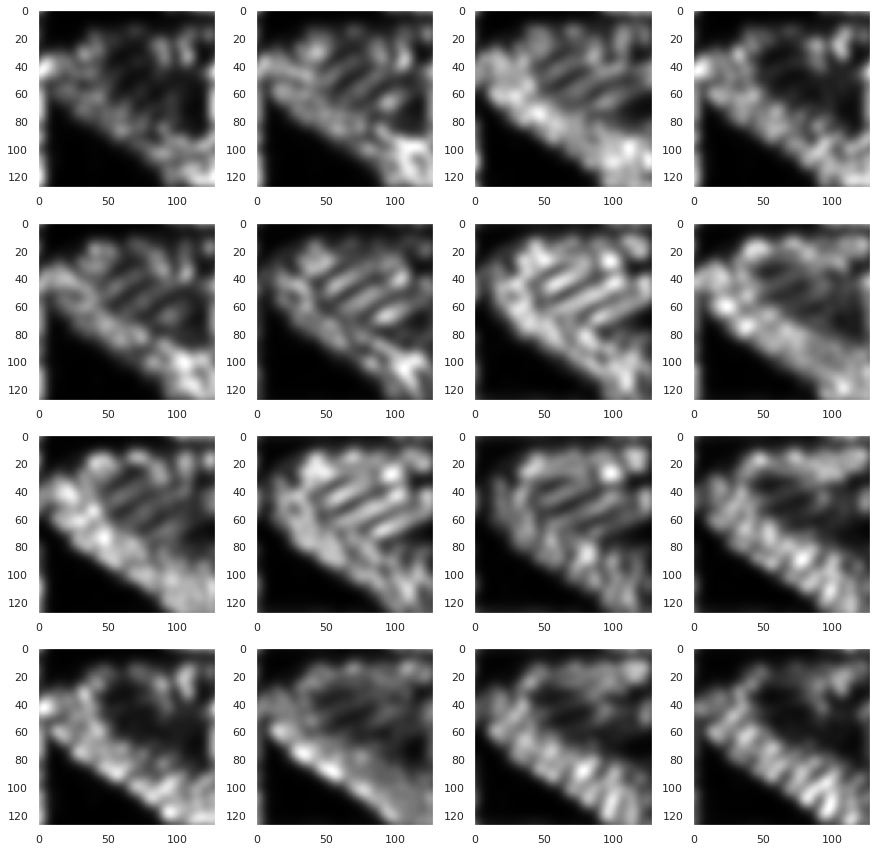

In [20]:
c = 1
plt.figure(figsize = (15,15))
for j in range(num_angles**2):
    plt.subplot(4,num_angles,c)
    plt.imshow(scattering_coeff[:,:,5+j], cmap = 'gray')
    plt.grid(False)
    c = c+1

# Preprocessing Digits Dataset Using Scattering

Let's try this algorithm out on the digits dataset. We'll use 10% of our data for training and the other 90% for testing with an SVM classifier as our classifier.

In [34]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X,y = load_digits(return_X_y = True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)
x_train_reshaped = np.reshape(x_train, (x_train.shape[0],8,8))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0],8,8))
sigma = 0.85
xi = [0 , np.pi * 3/5]
depth  = 2
num_angles = 4
num_coeff = 0

for n in range(depth+1):
    num_coeff += num_angles**n

psi = high_pass_wavelets(8, sigma1, xi, num_angles, depth)
phi = low_pass_wavelet(8, sigma2 , depth)

wavelet_coeff_x_train = np.zeros((x_train.shape[0], x_train.shape[1] * num_coeff), dtype = 'float')
for n in range(x_train.shape[0]):
    x =  wavelet_scattering_transform(x_train_reshaped[n,:,:], psi, phi, xi, num_angles, depth)
    wavelet_coeff_x_train[n,:] = np.reshape(np.abs(x), x_train.shape[1] * num_coeff)

wavelet_coeff_x_test = np.zeros((x_test.shape[0], x_test.shape[1] * num_coeff), dtype = 'float')
for n in range(x_test.shape[0]):
    x =  wavelet_scattering_transform(x_test_reshaped[n,:,:], psi, phi, xi, num_angles, depth)
    wavelet_coeff_x_test[n,:] = np.reshape(np.abs(x), x_test.shape[1] * num_coeff)

# SVM on Digits Dataset with Scattering

In [35]:
from sklearn import svm

lin_clf = svm.LinearSVC(max_iter = 100000)
lin_clf.fit(wavelet_coeff_x_train, y_train)
y_pred = lin_clf.predict(wavelet_coeff_x_test)

In [36]:
print("Prediction:")
print(y_pred)
print("Actual:")
print(y_test)
m = np.count_nonzero(y_pred-y_test)
print("The accuracy is", 1 - m/len(y_pred))

Prediction:
[6 9 3 7 2 2 5 2 5 2 1 9 4 0 4 2 3 7 8 8 4 3 9 7 5 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 9 2 9 0 4 4 4 3 5 3 1 3 5 9 4 2 7
 7 4 4 1 9 2 7 9 7 2 6 9 4 0 7 2 7 5 8 7 5 7 0 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 3 5 6 6 0 6 4 3 9 3 4 7 2 9 0 4 5 3 6 5 9 9 8 4 2 1 3 7 7 2 2 3 9 8 0 3
 2 2 5 6 9 9 4 1 5 4 2 3 6 4 8 5 9 5 7 8 9 4 8 1 5 4 4 9 6 1 8 6 0 4 5 2 7
 4 6 4 5 6 0 3 2 3 6 7 1 5 1 4 7 6 8 2 5 5 1 0 2 8 8 9 9 7 6 2 2 2 3 4 8 8
 3 6 0 9 7 7 0 1 0 4 5 1 5 3 6 0 4 1 0 0 3 6 5 9 7 3 5 5 9 9 8 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 1 3 1 4 1 1 7 0 1 5 2 1 2 8 7 0 6 4 8 8 5 1 8
 4 5 8 7 9 8 5 0 6 2 0 7 9 8 9 5 2 7 7 1 8 7 4 3 0 3 5 6 0 0 3 0 5 0 0 4 1
 2 8 4 5 4 6 3 1 8 8 4 2 3 0 9 8 8 5 0 6 3 3 7 1 6 4 1 2 1 1 6 4 7 4 8 3 4
 0 5 1 9 4 5 7 6 3 7 0 5 9 7 5 9 7 4 2 1 9 0 7 5 3 3 6 3 9 6 9 5 0 1 5 5 8
 3 3 6 2 6 5 7 2 0 8 7 3 7 0 2 2 3 5 8 7 3 6 5 9 9 2 5 6 3 0 7 1 1 9 6 1 8
 0 0 2 9 3 7 

# SVM on Digits without Scattering

We now run a standard SVM algorithm classifier just using the digits dataset with no modification as a baseline algorithm. Here are the results:

In [37]:
from sklearn import svm

lin_clf = svm.LinearSVC(max_iter = 1000000)
lin_clf.fit(x_train, y_train)
y_pred = lin_clf.predict(x_test)

In [38]:
print("Prediction:")
print(y_pred)
print("Actual:")
print(y_test)
m = np.count_nonzero(y_pred-y_test)
print("The accuracy is", 1 - m/len(y_pred))

Prediction:
[6 9 3 7 2 2 5 2 5 2 1 8 4 0 4 2 3 7 8 8 4 3 9 7 1 6 3 5 6 3 4 9 1 4 4 6 9
 4 7 6 6 9 1 3 6 1 3 0 6 5 5 1 9 5 6 0 9 0 0 1 0 4 5 2 4 5 7 0 7 5 9 5 5 4
 7 0 4 5 5 9 9 0 2 3 8 0 6 4 4 9 1 2 8 3 5 2 9 4 4 4 4 3 5 3 1 8 5 9 4 2 7
 7 4 4 1 9 2 7 8 7 2 6 9 4 0 7 2 7 5 8 7 5 7 9 0 6 6 4 2 8 0 9 4 6 9 9 6 9
 0 3 5 6 6 0 6 4 3 9 3 8 7 2 9 0 4 5 8 6 5 8 9 8 4 2 1 3 7 7 2 2 3 9 8 0 3
 2 1 5 6 9 9 4 1 5 4 2 3 6 4 8 5 9 5 7 8 9 4 8 1 5 4 4 9 6 1 8 6 0 4 5 2 7
 4 6 4 5 6 0 3 2 3 6 7 1 5 2 4 7 6 5 8 5 5 1 5 2 8 8 9 8 7 6 2 2 2 3 4 8 8
 3 6 0 9 7 7 0 1 0 4 5 8 5 3 6 0 4 1 0 0 3 6 5 9 7 3 5 5 9 9 0 5 3 3 2 0 5
 8 3 4 0 2 4 6 4 3 4 5 0 5 2 1 3 1 4 1 1 7 0 8 5 2 1 2 8 7 0 6 4 8 8 5 1 8
 4 5 8 7 9 8 6 0 6 1 0 7 9 1 9 5 2 7 7 1 8 7 4 3 8 3 5 6 0 0 3 0 5 0 0 4 1
 2 8 8 5 9 6 3 4 8 8 4 2 3 8 9 8 8 5 0 6 3 3 7 1 6 4 8 2 1 1 6 4 7 4 8 3 4
 0 5 1 3 4 5 7 6 3 7 0 5 9 7 5 9 7 4 2 2 9 0 7 5 8 3 6 3 9 6 9 5 0 1 5 5 8
 7 3 6 2 6 5 7 2 0 8 7 3 7 0 2 2 3 5 8 7 3 6 5 9 9 2 1 6 3 0 7 2 1 9 6 1 8
 0 0 2 9 3 9 

After convergence, it seems like the scattering transform 
gave us about a 4% accuracy boost. A better test would be to use this on a larger dataset to see if the improvements are actually more drastic.

# Making "Scattering Faces"
Morlet wavelets are usually good for edge detection, so let's try applying the scattering transform to an image of someone. 


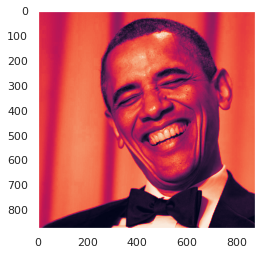

In [23]:
# Load image and crop 
obama_orig = mpimg.imread('/content/drive/MyDrive/barack-obama-laughs.jpg')
obama = obama_orig[:874,:874,0] / 255
plt.imshow(obama)
plt.grid(False)

In [24]:
sigma1 = 0.85
sigma2 = 1
xi = [0 , np.pi * 3/5]
depth  = 2
num_angles = 4
psi = high_pass_wavelets(obama.shape[0], sigma1, xi, num_angles, depth)
phi = low_pass_wavelet(obama.shape[0], sigma2 , depth)

In [25]:
obama_coeff = wavelet_scattering_transform(obama, psi, phi, xi, num_angles, depth)

In [26]:
obama_coeff = np.abs(obama_coeff)

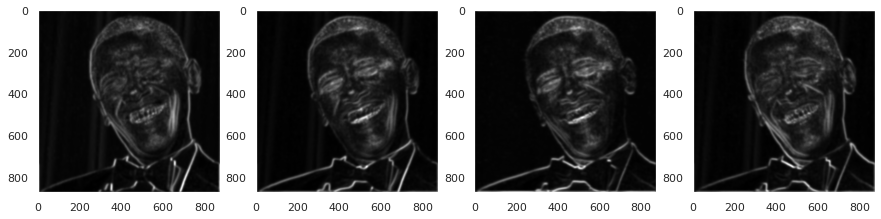

In [27]:
c = 1
plt.figure(figsize = (15,4))
for j in range(num_angles):
    plt.subplot(1,num_angles,c)
    plt.imshow(obama_coeff[:,:,j+1], cmap = 'gray')
    plt.grid(False)
    c = c+1

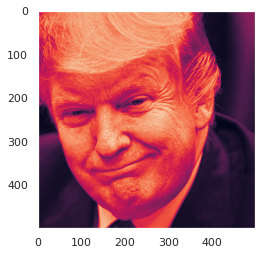

In [28]:
# Load image and crop 
trump_orig = mpimg.imread('/content/drive/MyDrive/1000x-1.jpg')
trump = trump_orig[:500,350:850,0] / 255
plt.imshow(trump)
plt.grid(False)

In [30]:
sigma1 = 0.85
sigma2 = 1
xi = [0 , np.pi * 3/5]
depth  = 2
num_angles = 4
psi = high_pass_wavelets(trump.shape[0], sigma1, xi, num_angles, depth)
phi = low_pass_wavelet(trump.shape[0], sigma2 , depth)

In [31]:
trump_coeff = wavelet_scattering_transform(trump, psi, phi, xi, num_angles, depth)

In [32]:
trump_coeff = np.abs(trump_coeff)

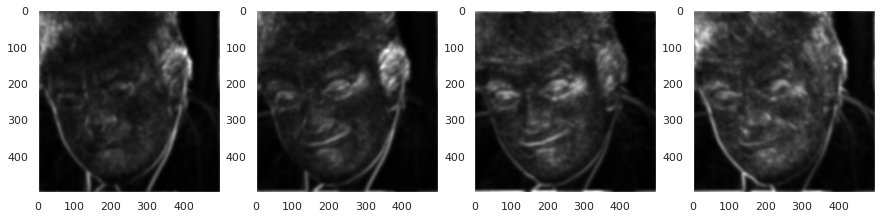

In [33]:
c = 1
plt.figure(figsize = (15,4))
for j in range(num_angles):
    plt.subplot(1,num_angles,c)
    plt.imshow(trump_coeff[:,:,j+1], cmap = 'gray')
    plt.grid(False)
    c = c+1